<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Цель**  

Построить модель для определения количества заказов такси. 

**Структура исследования**  

1. Подготовка данных
2. Анализ данных
2. Обучение моделей
3. Тестирование

**Использование дополнительных модулей**  

- `pandas` – редактор баз данных  
- `statsmodels` – обработка временных рядов
- `sklearn`, `catboost`, `lightgbm` – машинное обучение
- `matplotlib` – визуализация 

## Подготовка

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [2]:
# Загрузка данных из файла, присваивание индекса и его парсинг
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [3]:
# Общая информация о датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# Проверка отсутствия пропусков данных
df.isna().sum()

num_orders    0
dtype: int64

In [5]:
# Проверка индекса на монотонность
df.index.is_monotonic

True

### Вывод

Данные подготовлены для последующей обработки.

## Анализ

In [6]:
# Ресемплирование по одному часу
df.sort_index(inplace=True)
df_by_hour = df.resample('1H').sum()
df_by_hour.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


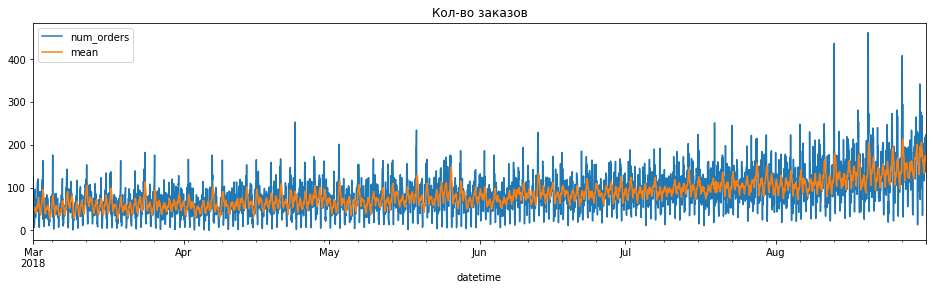

In [7]:
# Построим график и дополним его кривой со скользящим средним
df_by_hour['mean'] = df_by_hour['num_orders'].rolling(10).mean()
df_by_hour.plot(title='Кол-во заказов', figsize=(16, 4));

In [8]:
df_by_hour.drop('mean', axis=1, inplace=True)

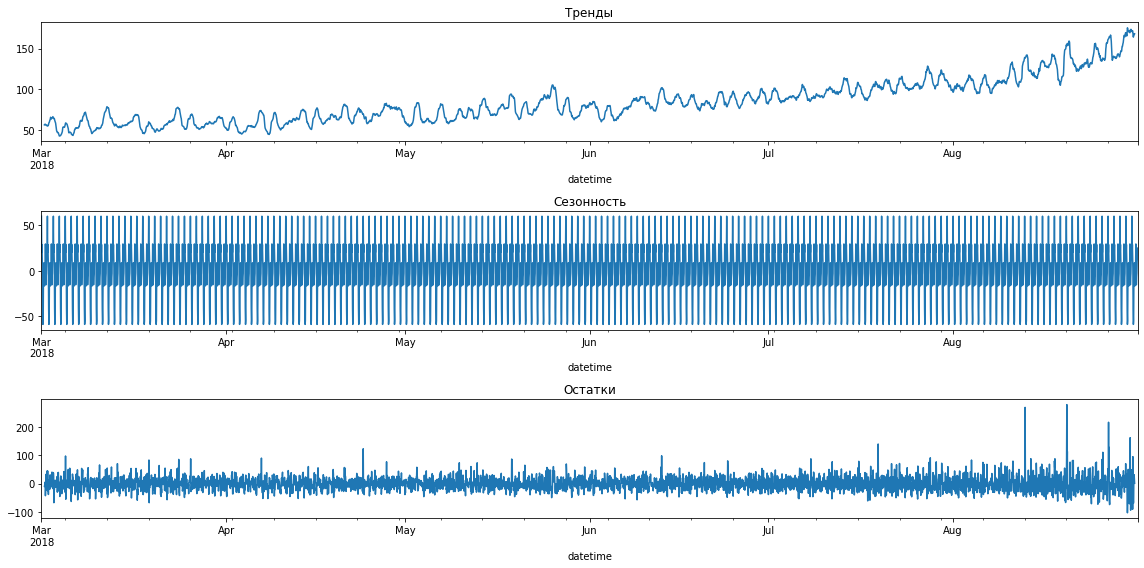

In [9]:
# Визуализируем тренды и сезонность
decomposed = seasonal_decompose(df_by_hour)

plt.figure(figsize=(16, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Тренды')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Остатки')
plt.tight_layout()

In [10]:
# Выделим небольшой интервал (начало – понедельник) из графика тренда
df_april_weeks = df_by_hour['2018-04-09':'2018-04-22']
df_april_weeks_copy = df_april_weeks.copy()

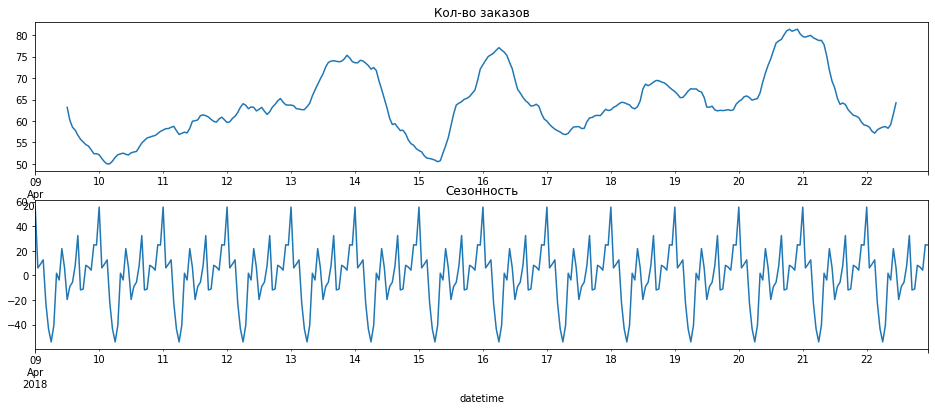

In [11]:
# Визуализируем тренды и сезонность
decomposed_april = seasonal_decompose(df_april_weeks_copy)

plt.figure(figsize=(16, 6))

plt.subplot(211)
decomposed_april.trend.plot(ax=plt.gca())
plt.title('Кол-во заказов')

plt.subplot(212)
decomposed_april.seasonal.plot(ax=plt.gca())
plt.title('Сезонность');

### Выводы

Тренд показывает устойчивый рост с каждым новым месяцем. Заметна характерная «сезонность». При более подробном рассмотрении двухнедельного среза можно выделить следующее: со вторника по пятницу нарастает число заказов, в субботу фиксируется постоянный устойчивый спрос на услуги, самый спокойный день с минимальным числом заказов – вторник (10 и 17 число соответственно).

## Обучение

In [12]:
# Функция для создания дополнительных признаков
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df_by_hour, 1, 24) # 24-часа

In [13]:
# Разделение подготовленного датафрейма на выборки
train, test = train_test_split(df_by_hour, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()

X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders']

print('Размер обучающей выборки признаков', X_train.shape)
print('Размер обучающей выборки меток', y_train.shape)
print('Размер тестовой выборки признаков', X_test.shape)
print('Размер тестовой выборки меток', y_test.shape)

Размер обучающей выборки признаков (3950, 4)
Размер обучающей выборки меток (3950,)
Размер тестовой выборки признаков (442, 4)
Размер тестовой выборки меток (442,)


In [14]:
# Создаем функцию для оценки метрики 'RMSE' для моделей машинного обучения
def model_check(model):
    """
    Функция принимает на вход модель для машинного обучения
    
    возвращает: RMSE
    """

    model.fit(X_train, y_train)
    predict = model.predict(X_test)

    rmse = mean_squared_error(y_test, predict, squared=False)
    
    return predict, round(rmse, 2)

In [15]:
# Последовательно вызываем созданную функцию для выбранных моделей

# LinearRegression()
pred_lr, rmse_lr = model_check(LinearRegression())

# CatBoostRegressor()
pred_cb, rmse_cb = model_check(CatBoostRegressor(silent=True, random_state=12345))

# LGBMRegressor()
pred_lgbm, rmse_lgbm = model_check(LGBMRegressor(random_state=12345))

# Собираем результаты в сводную таблицу
pivot_table = pd.DataFrame(data=[rmse_lr, rmse_cb, rmse_lgbm], columns=['RMSE'], index=['LinearRegression', 'CatBoostRegressor', 'LGBMRegressor'])
pivot_table.sort_values('RMSE')

,RMSE
LGBMRegressor,43.39
CatBoostRegressor,43.70
LinearRegression,51.19


In [16]:
# Подбор гиперпараметров для лучшей модели
lgbm = LGBMRegressor(random_state=12345)

n_estimators = range(10, 120, 10)
max_depth = range(1, 10)

hyperparameters = dict(n_estimators=n_estimators, max_depth=max_depth)

tscv = TimeSeriesSplit() # использовал настройки по умолчанию

gridsearch = GridSearchCV(lgbm, hyperparameters, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, verbose=0)

best_model_tscv = gridsearch.fit(X_train, y_train)

predict_best_tscv = best_model_tscv.predict(X_test)

rmse_best_tscv = mean_squared_error(y_test, predict_best_tscv, squared=False)

print('Лучший параметр n_estimators:', best_model_tscv.best_estimator_.get_params()['n_estimators'])
print('Лучший параметр max_depth:', best_model_tscv.best_estimator_.get_params()['max_depth'])

print('Лучшая метрика RMSE', round(rmse_best_tscv, 2))

Лучший параметр n_estimators: 90
Лучший параметр max_depth: 7
Лучшая метрика RMSE 42.96


### Выводы

Преодолен порог (`RMSE` = 48) в рамках учебного задания. Лучший результат показала модель машинного обучения `LGBMRegressor`.  

Подбор гиперпараметров позволил улучшить качество модели (приблизительно на 1.0%, 43.39/42.96).

## Тестирование

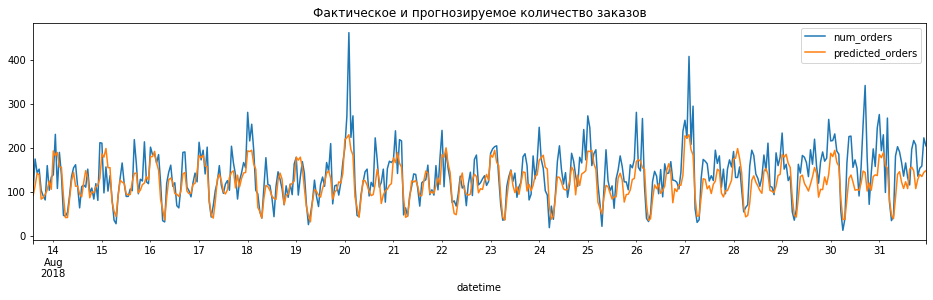

In [17]:
# Визуализируем фактические данные по заказам и прогнозируемые от лучшей модели машинного обучения
df_true = pd.DataFrame(data=y_test)
df_pred = pd.DataFrame(predict_best_tscv, columns=['predicted_orders'], index=y_test.index)

pd.concat([df_true, df_pred], axis=1).plot(title='Фактическое и прогнозируемое количество заказов', figsize=(16, 4));

### Выводы

Модель машинного обучения с подбором гиперпараметров описывает фактические данные с минимальной погрешностью.